<a href="https://colab.research.google.com/github/Dkreitzer/Text_ML_Classification_UMN/blob/master/Doc_Classification_Safe.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**bold text**# references
https://towardsdatascience.com/applying-machine-learning-to-classify-an-unsupervised-text-document-e7bb6265f52


# Imports and Installs

In [1]:
#@title Default title text { vertical-output: true }
#@markdown this is random markdown

!pip install markdown2
from __future__ import print_function
from nltk.stem.snowball import SnowballStemmer
import string
from nltk.tag import pos_tag
from gensim import corpora, models, similarities
from sklearn.externals import joblib
from sklearn.metrics import euclidean_distances
from sklearn.metrics.pairwise import cosine_similarity
import colorsys
import markdown2


import seaborn as sns
from scipy.sparse import coo_matrix
from sklearn.metrics import silhouette_samples, silhouette_score
import sys
from operator import itemgetter
import time
from tqdm.auto import tqdm
import re

from datetime import datetime
from nltk.corpus import stopwords
from nltk import word_tokenize, sent_tokenize
from nltk.stem import PorterStemmer
from nltk import pos_tag
import nltk
import math
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from matplotlib import figure
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.cluster import KMeans
from sklearn import metrics
from IPython.display import display, HTML

import numpy as np  ##20.2
import pandas as pd
from pandas.io.common import EmptyDataError

import matplotlib
from pathlib import Path
import shutil
import string

import ipywidgets as widgets


nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')

%matplotlib inline

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


#Downloading Files


In [2]:
#@title Get/Replace Github
get_new = True #@param {type:"boolean"}

remove_old = False #@param {type:"boolean"}
if remove_old:
  double_check = input(
      'Make sure to backup master_data.csv Enter "Delete" to continue? ').lower()
  if double_check == "delete":
      !rm -rf Text_ML_Classification_UMN
if get_new:
    !git clone https://github.com/Dkreitzer/Text_ML_Classification_UMN
      

Cloning into 'Text_ML_Classification_UMN'...
remote: Enumerating objects: 3180, done.
remote: Counting objects: 100% (3180/3180), done.
remote: Compressing objects: 100% (3104/3104), done.
remote: Total 3180 (delta 79), reused 3148 (delta 60), pack-reused 0
Receiving objects: 100% (3180/3180), 64.04 MiB | 19.30 MiB/s, done.
Resolving deltas: 100% (79/79), done.
Checking out files: 100% (3129/3129), done.


In [47]:
  #@title Move Files for Testing
  shutil.move('Text_ML_Classification_UMN/Train/Text_Files_Trained/ASGN_Incorporated.txt', 'Text_ML_Classification_UMN/Analyze')
  shutil.move("Text_ML_Classification_UMN/Train/Text_Files_Trained/AAR_Corp_.txt", 'Text_ML_Classification_UMN/Analyze')
  shutil.move("Text_ML_Classification_UMN/Train/Text_Files_Trained/2U_Inc_.txt", 'Text_ML_Classification_UMN/Analyze')
  shutil.move("Text_ML_Classification_UMN/Train/Text_Files_Trained/3M_Company.txt", 'Text_ML_Classification_UMN/Analyze')
  shutil.move("Text_ML_Classification_UMN/Train/Text_Files_Trained/ADT_Inc_.txt", 'Text_ML_Classification_UMN/Analyze')
  shutil.move("Text_ML_Classification_UMN/Train/Text_Files_Trained/180_Degree_Capital_Corp_.txt", 'Text_ML_Classification_UMN/Analyze')


'Text_ML_Classification_UMN/Analyze/180_Degree_Capital_Corp_.txt'

In [3]:
#@title get_time Helper Function { vertical-output: true }
def get_time():
    current_time = datetime.now().strftime("%b%d-%I%M%p")
    return current_time
get_time()

'Mar20-0523AM'

In [4]:
#@title get_documents() { vertical-output: true }

def get_documents(NUMBER_OF_DOCS):
    doclist = []
    names = []
    # %cd "
    pathlist = Path(
        "Text_ML_Classification_UMN/Train/Text_Files_Trained").glob('**/*.txt')

    for path in tqdm(pathlist):
        path_in_str = str(path)
    #     print(path_in_str)
        name = path_in_str.split(".")[0].split("/")[3]
        names.append(name.replace("_", " "))
        # TODO SPLIT PATH TO COMPANY NAME, make Index
        file = open(path, "r", encoding= 'Windows-1252')
        # print "Output of Readlines after appending"
        text = file.readlines()
    #     print(text[:10])
        doclist.append(text[0])
      
      
            
    df_to_split = pd.DataFrame(list(zip(names, doclist)),
                               columns=['Company', 'Text'])
    split_df = df_to_split.sample(n=NUMBER_OF_DOCS, random_state=42)
    doclist, names =  split_df["Text"].tolist(), split_df["Company"].tolist()
    print(split_df.head())
    
    
    
    return doclist, names
doclist, names = get_documents(100)


                             Company  \
2115  Flushing Financial Corporation   
457       R R Donnelley Sons Company   
1820      Iridium Communications Inc   
2413        Arcadia Biosciences Inc    
564   Progenics Pharmaceuticals Inc    

                                                   Text  
2115  [1] "Item 1A.Risk Factors.. In addition to the...  
457   [1] "ITEM  1A.  RISK FACTORS. Our consolidated...  
1820  [1] "Item 1A. Risk Factors. Our business plan ...  
2413  [1] "Item 1A. Risk Factors.. You should carefu...  
564   [1] "Item 1A. Risk Factors. General Risks Rela...  


# Vectorization
In order to run the model, we need to turn words in to numbers <br>
First, we turn each document into Sentences or tokens <a href="#Token">Tokenization</a>  <br>
To remove digits, useless words and characters we use a  <a href="#Filter">Filter</a>   <br>
Finally, we <a href="#Stem">Stem</a>   each token into its word root <br>
Then we can use some sort of <a href="#Vector">Vectorizer</a> to generate our input!


In [5]:
#@title transform_tokens() { vertical-output: true }
def transform_tokens(doclist):
    token_list = []
    for doc in tqdm(doclist, desc="Tokenizing", leave=True, position=0):
        dirty_tokens = nltk.sent_tokenize(doc)
        token_list += [dirty_tokens]
    return token_list
tokens = transform_tokens(doclist)
tokens[0][:5]

['[1] "Item 1A.Risk Factors..',
 'In addition to the other information contained in this Annual Report, the following factors and other considerations should be considered carefully in evaluating us and our business.. Changes in Interest Rates May Significantly Impact Our Financial Condition and Results of Operations.',
 'Like most financial institutions, our results of operations depend to a large degree on our net interest income.',
 'When interest-bearing liabilities mature or reprice more quickly than interest-earning assets, a significant increase in market interest rates could adversely affect net interest income.',
 'Conversely, a significant decrease in market interest rates could result in increased net interest income.']

In [6]:
#@title transform_filtered() { vertical-output: true }
def transform_filtered(token_list, doclist, names):

    punc = ['.', ',', '"', "'", '?', '!', ':',
            ';', '(', ')', '[', ']', '{', '}', "%"]
    more_stops = ['\t',
                  '\\t\\t\\', '\\t\\t\\t',
                  '<U+25CF>', '<u+feff>',  '[1]', 'feff', '1a', 'item']
    maybe_bad_stops = ['may', 'could',  'contents',
                       'table', 'time', '25cf', 'factors', 'risk']
    stopwords_list = stopwords.words(
        'english') + more_stops + punc + maybe_bad_stops
    filtered_tokens = []
    names_list = []
    
    if type(token_list) != list:
        token_list = [token_list]
    index = 0
              
    for document in tqdm(token_list, desc="Filtering Documents"):
        name = names[index]
        for token in document:
            filtered_token = [word.lower() for word in token.split(
                " ") if word.lower() not in stopwords_list and word.isalpha()]
            filtered_token = ' '.join(filtered_token)
            if len(filtered_token) != 0:
                names_list.append(name)
                filtered_tokens.append(filtered_token)
        index += 1
    
    return filtered_tokens, names_list, stopwords_list
  
  
filtered_tokens, names_list, stopwords_list = \
transform_filtered(tokens, doclist, names)
filtered_tokens[:25]


['addition information contained annual following considerations considered carefully evaluating us changes interest rates significantly impact financial condition results',
 'like financial results operations depend large degree net interest',
 'liabilities mature reprice quickly significant increase market interest rates adversely affect net interest',
 'significant decrease market interest rates result increased net interest',
 'general seek manage business limit overall exposure interest rate',
 'fluctuations market interest rates neither predictable controllable material adverse impact operations financial',
 'rising interest rate ability repay adjustable rate mortgages negatively affected payments increase repricing',
 'prevailing interest rates also affect extent borrowers repay refinance',
 'declining interest rate number loan prepayments loan refinancing well prepayments',
 'call provisions associated investment government agency corporate securities also adversely affect yiel

In [7]:
#@title transform_stemming() { vertical-output: true }
def transform_stemming(filtered_tokens):
    stemmed = []
    for token in tqdm(filtered_tokens, desc="Stemming"):
        sentence = []
        stemmed_token = \
        [PorterStemmer().stem(word) for word in token.split(" ")]
        stemmed_token = \
        [word for word in stemmed_token if word not in stopwords_list]
#         stemmed_token = \
#         [LancasterStemmer().stem(word) for word in token.split(" ")]
#         stemmed_token = \
#         [SnowballStemmer('english').stem(word) for word in token.split(" ")]

        stemmed_token = ' '.join(stemmed_token)
        stemmed.append(stemmed_token)

    return stemmed

  
stemmed = transform_stemming(filtered_tokens)
stemmed[:5]

['addit inform contain annual follow consider consid care evalu us chang interest rate significantli impact financi condit result',
 'like financi result oper depend larg degre net interest',
 'liabil matur repric quickli signific increas market interest rate advers affect net interest',
 'signific decreas market interest rate result increas net interest',
 'gener seek manag busi limit overal exposur interest rate']

In [8]:
#@title transform_vectorize() { vertical-output: true, form-width: "50%" }
#@markdown TF-IDF Vectorizer

def transform_vectorize(stemmed, smallest_ngram, largest_ngram):

    vectorizer = TfidfVectorizer(stop_words=stopwords_list,
                                 ngram_range=(smallest_ngram, largest_ngram),
                                 max_df=0.55, min_df=0.01)
    count_vectorizer = CountVectorizer(stop_words=stopwords_list,
                                   ngram_range=(smallest_ngram, largest_ngram),
                                   max_df=0.75, min_df=0.01)
    sparseMatrix = vectorizer.fit_transform(stemmed)
    
    return sparseMatrix, vectorizer, count_vectorizer
 


smallest_ngram = 1
largest_ngram = len(max(tokens, key=len))
%time sparseMatrix, vectorizer, count_vectorizer = \
transform_vectorize(stemmed, smallest_ngram, largest_ngram)
vectorizer

CPU times: user 30.1 s, sys: 1.23 s, total: 31.4 s
Wall time: 31.4 s


TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.55, max_features=None, min_df=0.01,
        ngram_range=(1, 1077), norm='l2', preprocessor=None,
        smooth_idf=True,
        stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs',...)', '[', ']', '{', '}', '%', 'may', 'could', 'contents', 'table', 'time', '25cf', 'factors', 'risk'],
        strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

In [9]:
#@title Matrix as array{ vertical-output: true, form-width: "50%" }
print(sparseMatrix.toarray(), sparseMatrix.shape)
count_matrix = count_vectorizer.fit_transform(stemmed).toarray() 
print(count_matrix, count_matrix.shape)


[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.22767784 0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]] (34052, 354)
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [1 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]] (34052, 354)


In [10]:
#@title Visualizing The Vectors { vertical-output: true, form-width: "50%" }

def plot_coo_matrix(m):
    if not isinstance(m, coo_matrix):
        m = coo_matrix(m)
    fig = plt.figure()
    ax = fig.add_subplot(111, facecolor='black')
    ax.plot(m.col, m.row, 's', color='white', ms=1)
    ax.set_xlim(0, m.shape[1])
    ax.set_ylim(0, m.shape[0])
    ax.set_aspect('equal')
    for spine in ax.spines.values():
        spine.set_visible(False)
    ax.invert_yaxis()
    ax.set_aspect('equal')
    ax.set_xticks([])
    ax.set_yticks([])
    return ax
  
# print(sparseMatrix)
plot_coo_matrix(sparseMatrix).figure.show()

# Model Training

In [11]:
#@title Grid Search Paramaters
max_iter = 10, 50, #@param {type:"raw"}
n_clusters = 10, 20, 25, 30, 35,21,13,14,15 #@param {type:"raw"}

cross_validation_folds = 4 #@param {type:"integer"}
n_jobs = 100 #@param {type:"slider", min:1, max:1000, step:1}
verbose = 10 #@param {type:"slider", min:1, max:10, step:1}


from sklearn.model_selection import GridSearchCV
model = KMeans(init='k-means++', random_state=42, n_init=15
                   )
param_grid = {'max_iter': list(max_iter),
             'n_clusters': list(n_clusters),
              
             }
grid = GridSearchCV(model, param_grid, verbose=verbose, n_jobs=n_jobs, cv=cross_validation_folds)
grid.fit(sparseMatrix)

# lids = model.cluster_centers_

score = model.score(sparseMatrix)
silhouette_score = metrics.silhouette_score(sparseMatrix, labels, metric='euclidean')

# # List the best parameters for this dataset
print(grid.best_params_)
# # List the best score
print(grid.best_score_)

Fitting 4 folds for each of 18 candidates, totalling 72 fits


[Parallel(n_jobs=100)]: Using backend LokyBackend with 100 concurrent workers.
[Parallel(n_jobs=100)]: Done   9 out of  72 | elapsed:   39.3s remaining:  4.6min
[Parallel(n_jobs=100)]: Done  17 out of  72 | elapsed:   39.3s remaining:  2.1min
[Parallel(n_jobs=100)]: Done  25 out of  72 | elapsed:   39.3s remaining:  1.2min
[Parallel(n_jobs=100)]: Done  33 out of  72 | elapsed:   39.3s remaining:   46.5s
[Parallel(n_jobs=100)]: Done  41 out of  72 | elapsed:   39.3s remaining:   29.8s
[Parallel(n_jobs=100)]: Done  49 out of  72 | elapsed:   39.3s remaining:   18.5s
[Parallel(n_jobs=100)]: Done  57 out of  72 | elapsed:   39.3s remaining:   10.4s
[Parallel(n_jobs=100)]: Done  65 out of  72 | elapsed:   39.3s remaining:    4.2s


KeyboardInterrupt: ignored

In [0]:
#@title Kmeans
#@markdown <img src='https://upload.wikimedia.org/wikipedia/commons/d/d5/Kmeans_animation.gif'>

def estimator_cluster(sparseMatrix, vectorizer, params):
    model = KMeans(n_clusters=params['n_clusters'], init=params['init'],
                   max_iter=params['max_iter'], n_init=n_init,
                   random_state=params['random_state'],
                   precompute_distances = params['precompute_distances']
)
    model.fit(sparseMatrix)
#     import umap

#     model = umap.UMAP(n_neighbors=5,
#                       min_dist=0.3,
#                       metric='correlation').fit_transform(sparseMatrix)
    
    model_time = get_time()
    model_path = f'Text_ML_Classification_UMN/Model/model{model_time}.pkl'
    joblib.dump(model,  model_path)
    joblib.dump(vectorizer,  f'Text_ML_Classification_UMN/Model/vec{model_time}.pkl')
    order_centroids = model.cluster_centers_.argsort()[:, ::-1]
#     order_centroids = False
    terms = vectorizer.get_feature_names()
    print('Model Saved to %s' % model_path)
    return terms, order_centroids, model, n_clusters, model_time

In [0]:
init = "k-means++" #@param ["Pre-Labeled",'k-means++']
if init == "Pre-Labeled":
  init = get_origins(topics)
  n_clusters = init.shape[0]
else:
  n_clusters = 35 #@param {type:"integer"}

max_iter=50  #@param {type:"integer"}
n_init= 1 #@param {type:"integer"}
random_state=42  #@param {type:"integer"}
save_memory = False #@param ["False", "True"] {type:"raw"}



params = {"n_clusters" : n_clusters, "max_iter" : max_iter,
          'n_init' : n_init, 'random_state': random_state,
          'precompute_distances': save_memory, 'init': init }


In [16]:
#@title Model Results  { vertical-output: true }
%time terms, order_centroids, model, n_clusters, model_time =  \
  estimator_cluster(sparseMatrix, vectorizer, params)
print_score(model)

Model Saved to Text_ML_Classification_UMN/Model/modelMar20-0526AM.pkl
CPU times: user 45.3 s, sys: 4.91 s, total: 50.2 s
Wall time: 46.3 s


NameError: ignored

In [0]:
#@title Move Files?

train_to_history = False #@param {type:"boolean"}
analyze_to_history = False #@param {type:"boolean"}

def move_to_history(analysis_to_history, train_to_history):
    if train_to_history == True:
        pathlist = Path(
            "Text_ML_Classification_UMN/Train/Text_Files_Trained").glob('**/*.txt')
     
    if analyze_to_history == True:
        pathlist = Path(
            "/Text_ML_Classification_UMN/Analyze").glob('**/*.txt')
    
    if analyze_to_history or train_to_history:
        for path in tqdm(pathlist):
            shutil.move(str(path), 'Text_ML_Classification_UMN/History/Text_Files_History')

move_to_history(analyze_to_history, train_to_history)

# Loading Model

In [0]:
#@title load master_data() 
def load_master_data():
    master_path = 'Text_ML_Classification_UMN/Predicting/CSV/master_data.csv'
    try:
        master = pd.read_csv(master_path)
    except FileNotFoundError:
        master = False
    
    return master

In [0]:
#@title Print Score() { display-mode: "code" }
def print_score(model, vectorizer, stemmed):
    labels = model.labels_

#     print(f"Model Generated at {model_time}")

    print("Cluster id labels for inputted data")
    print(labels)
    print("Centroids data")
    #print (centroids)
    print("Paramaters")
    print(model.get_params)
    sparseMatrix = vectorizer.fit_transform(stemmed)
    kmeans_score = model.score(sparseMatrix)
    print("Score (Opposite of the value of X on the K-means objective, \n",
          "which is Sum of distances of samples to their closest cluster center):")
    print(kmeans_score)

    silhouette_score = metrics.silhouette_score(
        sparseMatrix, labels, metric='euclidean')

    print("Silhouette_score: ", silhouette_score)

    
    
    return kmeans_score, silhouette_score, sparseMatrix


In [0]:
def estimator_load_model(selection, stemmed):
      print(selection)
      model_time = selection
      vectorizer = joblib.load(
          f'Text_ML_Classification_UMN/Model/vec{model_time}.pkl')
      model = joblib.load(
          f'Text_ML_Classification_UMN/Model/model{model_time}.pkl')
      if stemmed:
          print_score(model, vectorizer, stemmed)
      n_clusters = model.n_clusters
      
      return model, vectorizer, n_clusters

In [20]:
#@title Model Selection { vertical-output: true }

pathlist = Path(
        "Text_ML_Classification_UMN/Model/").glob('**/*.pkl')

times = set([str(path).split(".pkl")[0].split("/")[2].replace(
        "model", "").replace("vec", "") for path in pathlist])
selection = widgets.Dropdown(
        options=times,
        description='Available Models:',
        disabled=False,
    )
display(selection)


Dropdown(description='Available Models:', options=('Mar20-0526AM', 'Feb14-0130PM'), value='Mar20-0526AM')

In [21]:
#@title Load model { vertical-output: true }
time = selection.value
model, vectorizer, n_clusters = estimator_load_model(time, stemmed)

Mar20-0526AM
Cluster id labels for inputted data
[11  1 11 ...  1 18  1]
Centroids data
Paramaters
<bound method BaseEstimator.get_params of KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=50,
    n_clusters=35, n_init=1, n_jobs=None, precompute_distances=False,
    random_state=42, tol=0.0001, verbose=0)>
Score (Opposite of the value of X on the K-means objective, 
 which is Sum of distances of samples to their closest cluster center):
-28279.333381331577
Silhouette_score:  0.03277581972844827


In [0]:
print(dir(model))

In [27]:
#@title Define Cluster Labels

#  https://stackoverflow.com/questions/876853/generating-color-ranges-in-python
order_centroids = model.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()

def get_N_HexCol(N):
    HSV_tuples = [(x * 1.0 / N, 0.5, 0.5) for x in range(N)]
    hex_out = []
    for rgb in HSV_tuples:
        rgb = map(lambda x: int(x * 255), colorsys.hsv_to_rgb(*rgb))
        hex_out.append('#%02x%02x%02x' % tuple(rgb))
    return hex_out

nclosest_words_to_show = 6
colormap = get_N_HexCol(n_clusters)



for label in range(n_clusters):
    nclosest_words = []
    color = colormap[label]
    display(HTML(f'<font color="{color}">Cluster {label}</font>'))
    for ind in order_centroids[label, :10]:
       nclosest_words.append(terms[ind])
    display(HTML(f'<font color="{color}">{nclosest_words}</font>'))

    

In [0]:
#@title Potential Topics { vertical-output: true }

#@markdown SUMMARIZATION OF CORPORATE RISK FACTOR DISCLOSURE THROUGH TOPIC MODELING by Bao, Datta
strings = [
    'Topic 0: investment, property, distribution, interest, agreement',
    'Topic 1: regulation, change, law, financial, operation, tax, accounting ',
    'Topic 2: gas, price, oil, natural, operation, production Input prices risks ',
    'Topic 3: stock, price, share, market, future, dividend, security, stakeholder ',
    'Topic 4: cost, regulation, environmental, law, operation, liability',
    'Topic 5: control, financial, internal, loss, reporting, history ',
    'Topic 6: financial, litigation, operation, condition, action, legal, liability, regulatory, claim, lawsuit'
    'Topic 7: competitive, industry, competition, highly',
    'Topic 8: cost, operation, labor, operating, employee, increase, acquisition ',
    'Topic 9: product, candidate, development, approval, clinical, regulatory',
    'Topic 10: tax, income, asset, net, goodwill, loss, distribution, impairment, intangible ',
    'Topic 11: interest, director, officer, trust, combination, share, conflict ',
    'Topic 12: product, liability, claim, market, insurance, sale, revenue Potential defects in products',
    'Topic 13: loan, real, estate, investment, property, market, loss, portfolio ',
    'Topic 14: personnel, key, retain, attract, management, employee ',
    'Topic 15: stock, price, operating, stockholder, fluctuate, interest, volatile  ',
    'Topic 16: acquisition, growth, future, operation, additional, capital, strategy ',
    'Topic 17: condition, economic, financial, market, industry, change, affected, downturn, demand Macroeconomic risks ',
    'Topic 18: system, service, information, failure, product, operation, software, network, breach, interruption Disruption of operations'
    'Topic 19: cost, contract, operation, plan, increase, pension, delay',
    'Topic 20: customer, product, revenue, sale, supplier, relationship, key, portion, contract, manufacturing, rely Rely on few large customers',
    'Topic 21: property, intellectual, protect, proprietary, technology, patent, protection, harm',
    'Topic 22: product, market, service, change, sale, demand, successfully, technology, competition Volatile demand and results',
    'Topic 23: provision, law, control, change, stock, prevent, stockholder, Delaware, charter, delay, bylaw',
    'Topic 24: regulation, government, change, revenue, contract, law, service',
    'Topic 25: capital, credit, financial, market, cost, operation, rating, access, liquidity, downgrade ',
    'Topic 26: debt, indebtedness, cash, obligation, financial, credit, ',
    'Topic 27: operation, international, foreign, currency, rate, fluctuation',
    'Topic 28: loss, insurance, financial, loan, reserve, operation, cover',
    'Topic 29: operation, natural, facility, disaster, event, terrorist, weather ']
topics = [topic.split(":")[1] for topic in strings]
targets = {
    "Shareholder’s interest risk": topics[0],
    "Regulation changes(accounting)": topics[1],
    "Stakeholder’s profit": topics[2],
    "Regulation changes(environment)": topics[3],
    "Legal Risks": topics[4],
    "Financial condition risks ": topics[5],
    " Potential/Ongoing Lawsuits": topics[6],
    "market Competition risks": topics[7],
    "**Labor cost ": topics[8],
    " New product introduction risks ": topics[9],
    "**Accounting,  +Restructuring risks ": topics[10],
    "**Management": topics[11],
    " Potential defects in products": topics[12],
    "**Investment": topics[13],
    "Human resource risks": topics[13],
    "Volatile stock price risks": topics[14],
    "Merger & Acquisition risks": topics[15],
    " +Industry is cyclical": topics[16],
    " **Postpone ":  topics[17],
    " +Infrastructure risks": topics[18],
    "+Suppliers risks +Downstream risks": topics[19],
    "license Intellectual property risks": topics[20],
    "+Licensing related risks' ": topics[21],
    "+ Competition risks ": topics[22],
    "*Potential/Ongoing Lawsuits*": topics[23],
    "Regulation changes": topics[24],
    "Credit risks": topics[25],
    "covenant Funding risks ": topics[26],
    "International risks": topics[27],
#     "Insurance" : topics[28],
#     "Catastrophes" : topics[29]
}

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

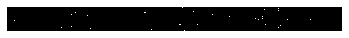

In [30]:
#@title get_origins() { vertical-output: true }
def get_origins(topics):
  string_in_a_list = np.empty([len(topics),1], dtype=str)
  tokens = transform_tokens(topics)
  filtered_tokens, _ , _ = transform_filtered(tokens, string_in_a_list, string_in_a_list)
  stemmed = transform_stemming(filtered_tokens)
  cluster_origins = vectorizer.transform(stemmed)
  plot_coo_matrix(cluster_origins)
  cluster_origins = cluster_origins.toarray()
  return cluster_origins
get_origins(targets)

# Predictions

In [42]:
#@title Predict String() { run: "auto", vertical-output: true, display-mode: "form" }

def estimator_predict_string(string):
    string_in_a_list = ["string"]
    
    print('Input String: %s' % string)
    print('\n')
    print('Prediction:')
    tokens = transform_tokens(string_in_a_list)
    filtered_tokens, _ , _ = transform_filtered(tokens, string_in_a_list, string_in_a_list)
    stemmed = transform_stemming(filtered_tokens)
    X = vectorizer.transform(stemmed)
    predicted = model.predict(X)



    color = colormap[predicted[0]]
    display(HTML(f'<font color="{color}">Predicted Cluster : {predicted[0]}</font>'))
    for ind in order_centroids[predicted[0], :10]:
       nclosest_words.append(terms[ind])
    display(HTML(f'<font color="{color}">{nclosest_words}</font>'))

    


Enter_a_String = 'This is a risky Year!' #@param {type:"string"}

estimator_predict_string(Enter_a_String)

Input String: This is a risky Year!


Prediction:


# Predict Documents

In [0]:
#@title Prediction helper functions { display-mode: "form" }
def estimator_predict_document(document, name):
    dictionary_list = []
    for counter, sentence in enumerate(document.split(".")):
        if len(sentence) != 0:
            vector_matrix = vectorizer.transform([sentence])
            predicted_label = model.predict(vector_matrix)
            sentence_len = len(sentence.split(" "))
            sentence_info = {'company': name, 'sentence#': counter, 'text': sentence,
                             'wordcount': sentence_len, 'label': predicted_label[0]}
            dictionary_list.append(sentence_info)
    dataframe = pd.DataFrame(dictionary_list)
    dataframe["% of total"] = dataframe['wordcount'] / \
        sum(dataframe['wordcount'])
#         (name, sentence, predicted_label)
    return(dataframe)
def prep_for_heatmap(muliple_company_frame):
    company_clusters = muliple_company_frame.groupby(['label', 'company']).agg(
        {'% of total': 'sum'}).unstack(level='company').fillna(0).T

    company_clusters = company_clusters.reset_index(level=0, drop=True)
    return company_clusters


In [110]:
#@title Predict Files { run: "auto", vertical-output: true, display-mode: "form" }
folder_choice =  'Samdbox' #@param ["Analyze", "Samdbox"] {type:"string"}

#@markdown Save Documents?
To_Master_List = False #@param ["False", "True"] {type:"raw"}
To_New_List =  True #@param ["False", "True"] {type:"raw"}

def analyze_documents():
  doclist = []
  names = []
  # %cd "
  pathlist = Path(
      "Text_ML_Classification_UMN/%s" % folder_choice).glob('**/*.txt')
# try:
  for path in tqdm(pathlist):
      path_in_str = str(path)
  #     print(path_in_str)
      name = path_in_str.split(".")[0].split("/")[2]
      names.append(name.replace("_", " "))
      # TODO SPLIT PATH TO COMPANY NAME, make Index
      file = open(path, "r", encoding= 'Windows-1252')
      # print "Output of Readlines after appending"
      text = file.readlines()
      doclist.append(text[0])



  analysis_df = pd.DataFrame(list(zip(names, doclist)),
                             columns=['Company', 'Text'])

  analysis_df.head()

  frames = []
  for document, name in zip(doclist, names):
      frame = estimator_predict_document(document, name)
      frames.append(frame)

  muliple_company_frame = pd.concat(frames)
  muliple_company_frame.head()
  grouped_frame = muliple_company_frame.groupby(
    ['company', 'label']).agg({'% of total': 'sum'}).reset_index()
  company_clusters = prep_for_heatmap(muliple_company_frame)
  master_path = "Text_ML_Classification_UMN/Predicting/CSV/master_data.csv"
  master = load_master_data()
  
  if type(master) != "pd.DataFrame" and To_Master_List == True:
      company_clusters.T.to_csv(master_path, header=True,index=False)
  master = load_master_data()

  if type(master) == "pd.DataFrame" and To_Master_List == True:
      master = pd.concat([master, company_clusters.T], ignore_index=True)
      master.to_csv(master_path, index=False)


      # if file does not exist write header 
      
#       with open(master_path, 'a') as f:
#           company_clusters.to_csv(f, header=f.tell()==0)
      
      ##!! THIS IS CAUSING DUPLICATES ##
      
      
       
    
  if To_New_List == True:
    analysis_time = get_time()

    with open(f'Text_ML_Classification_UMN/Predicting/CSV/{analysis_time}.csv', 'w') as f:
        company_clusters.T.to_csv(f, header=True)
#   except IndexError:
#     print("Are there any files in /Analyze?")
#     company_clusters, grouped_frame = len(names), False
  return company_clusters, grouped_frame, muliple_company_frame, master
company_clusters, grouped_frame, muliple_company_frame, master = analyze_documents()
company_clusters.T.head(20)


company,180 Degree Capital Corp,2U Inc,3M Company,AAR Corp,ADT Inc,ASGN Incorporated
label,,,,,,
1,0.594670,0.559028,0.449342,0.550567,0.495783,0.600069
3,0.005782,0.032401,0.064682,0.019924,0.056537,0.004856
4,0.004386,0.002758,0.022324,0.017150,0.001274,0.008151
5,0.027514,0.014190,0.053807,0.000000,0.057767,0.025321
7,0.008174,0.041075,0.029193,0.004792,0.020119,0.027402
8,0.143351,0.050899,0.000000,0.000000,0.071648,0.092092
11,0.026583,0.006147,0.000000,0.000000,0.021833,0.005376
12,0.001263,0.000000,0.017172,0.020681,0.019153,0.000000
13,0.013026,0.009134,0.000000,0.018663,0.010323,0.040062


In [0]:
from sklearn.neighbors import NearestNeighbors

model_tf_idf = NearestNeighbors(metric='cosine', algorithm='brute')
model_tf_idf.fit(sparseMatrix)

# Visualizations

  Currently Grabbing the files in Analysis, we could set this up for top and bottom N companies in the master list by Cluster ID




Make sure Png is located in Text_ML_Classification_UMN/Predicting/Images/ for html to work


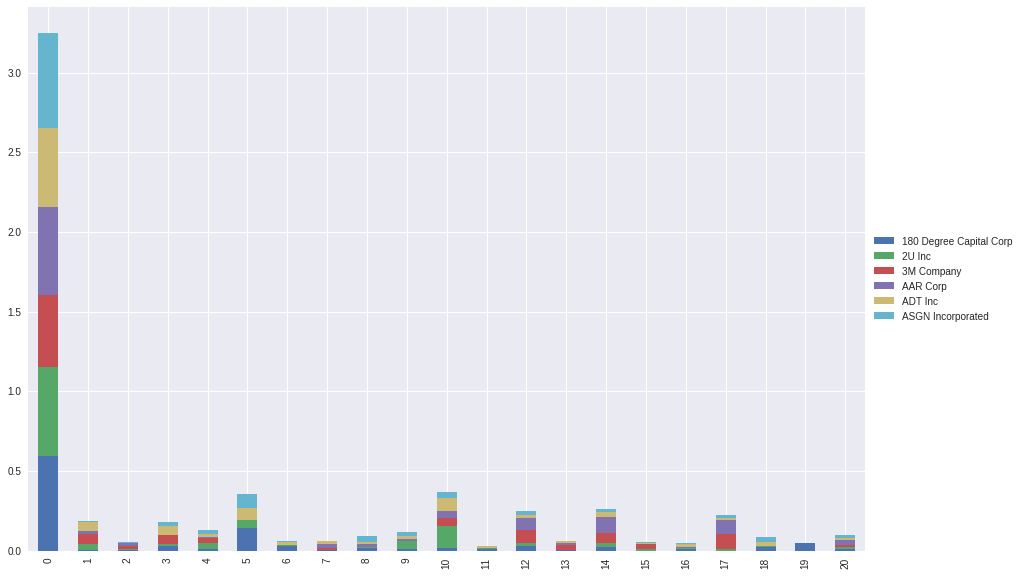

In [106]:
#@title Stacked Bar { run: "auto", vertical-output: true, display-mode: "form" }

folder = 'Master' #@param ["Analyze", "Master"]
html = True #@param ["False", "True"] {type:"raw"}
png= False #@param ["False", "True"] {type:"raw"}

f = plt.figure()
if folder == "Master":
  master = load_master_data()
  to_plot = master.reset_index(drop=True)
  to_plot.plot(kind='bar', stacked=True, figsize=(15,10), use_index=True, ax=f.gca())
else:
   company_clusters.plot(kind='bar', stacked=True, figsize=(15,10), use_index=True, ax=f.gca())

plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))


time = get_time()

if png == True or html == True:
  plt.savefig(f'Text_ML_Classification_UMN/Predicting/Images/stackedBar{time}.png')

if html == True:
  print("Make sure Png is located in Text_ML_Classification_UMN/Predicting/Images/ for html to work")
  Html_file= open(f'Text_ML_Classification_UMN/Predicting/Images/stackedBar{time}.html',"w")
  html_str = HTML(
      f'<img src="Text_ML_Classification_UMN/Predicting/Images/stackedBar{time}.png" alt={company_clusters.T.columns.values}>')
  Html_file.close()


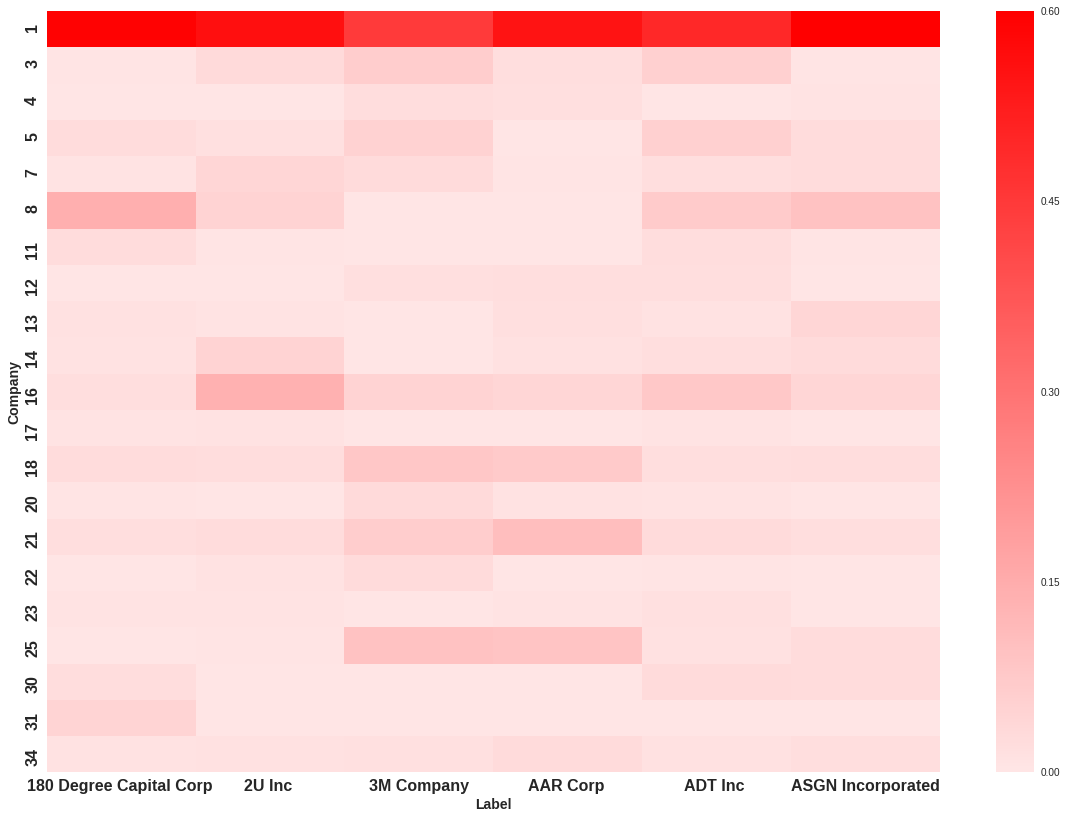

In [58]:
#@title Heatmap { vertical-output: true, display-mode: "form" }

def plot_heatmap(company_clusters, html, png):
    map_time = get_time()

    fig2, ax2 = plt.subplots(figsize=(20, 14))
    cmap = sns.light_palette('red', as_cmap=True)

    sns.heatmap(company_clusters, ax=ax2, cmap=cmap)
    

    ax2.set_xlabel('Label', fontdict={'weight': 'bold', 'size': 14})
    ax2.set_ylabel('Company', fontdict={'weight': 'bold', 'size': 14})
    for label in ax2.get_xticklabels():
        label.set_size(16)
        label.set_weight("bold")
    for label in ax2.get_yticklabels():
        label.set_size(16)
        label.set_weight("bold")


    if png == True or html == True:
        plt.savefig(
        "Text_ML_Classification_UMN/Predicting/Images/Heatmap{map_time}.jpg",
        dpi=None, facecolor='w', edgecolor='w',
                orientation='portrait', papertype=None, format=None,
                transparent=False, bbox_inches=None, pad_inches=0.1,
                frameon=None, metadata=None)

    if html == True:
        print(
            "Make sure Png is located in Text_ML_Classification_UMN/Predi" +
            "cting/Images/ for html to work")
        Html_file= open('Text_ML_Classification_UMN/Predicting/Images/Heat'+
                        f'map{time}.html',"w")
        html_str = HTML(
            '<img src="Text_ML_Classification_UMN/Predicting/Images/Heat' + 
            f'map{time}.png" alt={company_clusters.T.columns.values}>')
        Html_file.close()

#@markdown ## Save Image?


html = False #@param ["False", "True"] {type:"raw"}
png= True #@param ["False", "True"] {type:"raw"}

plot_heatmap(company_clusters.T, html, png)


In [105]:
#@title Generate Color Coded Text (Html) { vertical-output: true, display-mode: "form" }
#@markdown Save Text?
html = True #@param ["False", "True"] {type:"raw"}
display_all = False #@param {type:"boolean"}
display_lines = 10 #@param {type:"integer"}


for counter, company in enumerate(muliple_company_frame['company'].unique()):
  company = muliple_company_frame['company'].unique()[counter]
  companyFrame = muliple_company_frame[muliple_company_frame['company'] == company]
  if html == True:
      Html_file= open(f'Text_ML_Classification_UMN/Predicting/Text_Files/{company.replace(" ", "_")}_CC.html',"w")
  display(HTML(f'<h2>{company}</h2>'))


  
  for row in companyFrame.iterrows():
    
    color = colormap[row[1]['label']]
    text = row[1]['text']                
    html_str = HTML(f'<font color="{color}">' +
                       text + f'  ({row[1]["label"]})' + '</font>')
    if row[0] <= display_lines or display_all == True:
        display(html_str)
  if html == True:
    Html_file.close()

# Nearest Neighbors